# Testing the DistilBert fine-tuned on SST-2

In [19]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from datasets import load_dataset
import numpy as np
import evaluate
from scipy.special import softmax
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
import time

In [20]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")


In [21]:
dataset_test = load_dataset("csv", data_files="books_test.csv")

In [22]:
inputs = tokenizer(dataset_test['train']['body'], truncation=True, return_tensors="pt", padding=True)

In [6]:
with torch.no_grad():
    logits = model(**inputs).logits

## Calculating accuracy, precision, F1-score

In [7]:
load_accuracy = evaluate.load("accuracy")
load_f1 = evaluate.load("f1")
labels = dataset_test['train']['label']

predictions = np.argmax(logits, axis=-1)
accuracy = load_accuracy.compute(predictions=predictions, references=labels)
f1 = load_f1.compute(predictions=predictions, references=labels)
load_precision = evaluate.load("precision")
precision = load_precision.compute(predictions=predictions, references=labels)
metrics = {"accuracy": accuracy, "f1": f1, "precision": precision}

In [8]:
print(metrics)

{'accuracy': {'accuracy': 0.79}, 'f1': {'f1': 0.832}, 'precision': {'precision': 0.9811320754716981}}


### Accuracy is 0.79, F1-score is 0.832, precision is 0.98

In [9]:
#logits of the inference on the testing data
sst_dbert_logits = logits.numpy()

## PR curve: calculating precision and recall 

In [10]:
y_true = np.array(dataset_test["train"]["label"])
sst_dbert_precision = []
sst_dbert_recall = []
sst_dbert_probabilities = softmax(sst_dbert_logits, axis=1)
threshold = list(np.arange(0.0, 1, 0.001))
for t in threshold:
    y_scores = (sst_dbert_probabilities[:, 1] > t).astype(int)
    sst_dbert_precision.append(precision_score(y_true, y_scores, zero_division=1))
    sst_dbert_recall.append(recall_score(y_true, y_scores, zero_division=1))

sst_dbert_precision.append(1)
sst_dbert_recall.append(0)

## Baseline model which always returns the most frequent class

In [11]:
y_score_baseline = np.ones(y_true.shape)
baseline_precision = precision_score(y_true, y_score_baseline, zero_division=1)
baseline_recall = recall_score(y_true, y_score_baseline, zero_division=1)

## Plotting the PR curve

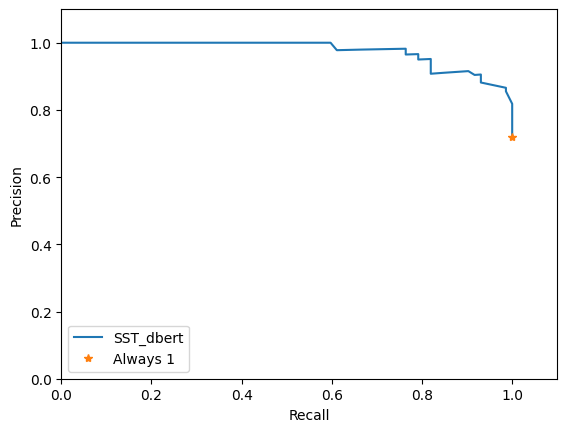

In [12]:
fig, ax = plt.subplots()
ax.plot(sst_dbert_recall, sst_dbert_precision, '-', label='SST_dbert')
ax.plot([baseline_recall], [baseline_precision], '*', label='Always 1')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_xlim((0, 1.1))
ax.set_ylim((0, 1.1))
ax.legend()

In [13]:
np.savetxt("sst_dbert_logits.csv", sst_dbert_logits, delimiter = ",")

## Estimating inference time

In [18]:
time_start = time.perf_counter()
model_cpu = model.to("cpu")

for text in dataset_test["train"]["body"]:
        request = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to('cpu')
        outputs = model_cpu(**request)

time_end = time.perf_counter()
    
print(f'Took {(time_end - time_start):.3f} seconds')

Took 6.547 seconds
